# Import

In [1]:
import fpmodules as fp
import pandas as pd
from evex_scout import *
from fpmodules.tools.constants import EVENTS_CACHE_PATH
from fpmodules.fpio.raw_data import load_data_from_files
from fpmodules.tools.dbtools import to_pdatime
from fpmodules import BlobManager
import matplotlib.pyplot as plt
import fpmodules.tools as tools

*** FP-modules version 2.10.13 ***


# Constants

In [3]:
RAWDATA_CACHE_PATH = os.path.join(EVENTS_CACHE_PATH, 'RawData')

SNR = 10
window_res = 10
step_interval = 1
window_size = 2
erosion_mask_length = 10
expand_dist = 600
hard_threshold = 5
saturation_threshold = 30000

# {1: "C", 2: "B", 3: "A", 4: "D"}
channels = [1, 1, 2, 2, 3, 3, 4, 4]
colors = tools.get_instrument_info()['Scout']['cmap']
tools.get_instrument_info()

{'SRS': {'channels': [808, 975]},
 'Scout': {'channels': ['970C',
   '810C',
   '970B',
   '810B',
   '970A',
   '810A',
   '970D',
   '810D'],
  'cmap': ['#0000F1',
   '#1E90FF',
   '#008040',
   '#20D100',
   '#F40000',
   '#F78528',
   '#481F01',
   '#957439'],
  'legend_img_path': 'SCOUT colour scheme skew.png'}}

# Get data

In [4]:
fp.get_session(sessionid=686)

,SessionId,StartTimeId,StartDateId,EndTimeId,EndDateId,UnitId,SubjectCompositionId,Name,SubscriptionId,MacAddress,Volito
0,686,151747,20210330,92009,20210419,18,149,Apis mellifera - Labelled - Taastrup transp.,15,dca6327d8fa8,20


In [5]:
fp.get_session(labelled=True)

,SessionId,StartTimeId,StartDateId,EndTimeId,EndDateId,UnitId,SubjectCompositionId,Name,SubscriptionId,MacAddress,Volito
0,23,151400,20200407,84200,20200421,14,24,Pollen Beetles,15,dca6327d908f,12
1,28,130000,20200522,80000,20200525,12,20,Fruitfly melanogaster,8,dca6327d7bf8,18
2,30,111000,20200425,110000,20200428,14,25,Cabbage stem weevil,15,dca6327d908f,12
3,32,84600,20200508,85200,20200515,24,26,Cabbage seed weevil,15,dca6327d8fa2,23
4,37,104600,20200609,100000,20200630,24,31,Pod Midge,15,dca6327d8fa2,23
...,...,...,...,...,...,...,...,...,...,...,...
391,1381,111702,20211126,<NA>,<NA>,158,125,Lucilia sp. - Labelled - Taastrup,15,dca632da494a,140
392,1382,113112,20211126,<NA>,<NA>,74,356,Sitobion avenae - Labelled - Taastrup,15,dca6323b4edf,67
393,1384,85625,20211129,<NA>,<NA>,153,125,1 Lucilia fly - Labelled - Taastrup,15,dca632da48e6,135
394,1385,85739,20211129,<NA>,<NA>,78,230,In-between 50%,15,e45f011d5b64,71


In [6]:
measurements = fp.dbquery('select * from measurement where sessionid=686')
measurements = measurements.sort_values('TimeId')
measurements = to_pdatime(measurements, delete=False)
measurements.head()

,Id,TimeId,DateId,MeasurementCode,UnitId,SessionId,Datetime
22628,37084806,37,20210407,338cc921621f7c00,18,686,2021-04-07 00:00:37
21552,37084824,557,20210407,6810ed6acf8ac800,18,686,2021-04-07 00:05:57
21553,37084825,558,20210407,77da2bf1d1dd7800,18,686,2021-04-07 00:05:58
4535,35434703,738,20210331,337f99c1e6771200,18,686,2021-03-31 00:07:38
25819,37993474,743,20210409,1d9514966ede0700,18,686,2021-04-09 00:07:43


In [7]:
insects = fp.get_insects(sessionid=686, all_segments=True)
insects.head()

,Classification,SegmentId,ClassifierId,MeasurementId,MeasurementCode,SessionId,UnitId,Datetime
0,1.0,2,31,35421615,2405079e1e82fe00,686,18,2021-03-30 16:03:15
1,1.0,4,31,35421616,64c9fd183fbf1c00,686,18,2021-03-30 16:03:20
2,1.0,2,31,35421616,64c9fd183fbf1c00,686,18,2021-03-30 16:03:20
3,1.0,3,31,35421616,64c9fd183fbf1c00,686,18,2021-03-30 16:03:20
4,1.0,1,31,35421616,64c9fd183fbf1c00,686,18,2021-03-30 16:03:20


# Define functions

In [8]:
def get_start_and_stop(data, times):
    fss = get_samplerates(times)
    fs = int(np.median(fss))
    data_matrix = data.copy() # transpose
    data_matrix, medians, stds, interp = remove_rolling_mean(data_matrix.astype(int), fs, window_res=window_res, step_interval=step_interval, window_size=window_size)
    event_mask_master = threshold(data_matrix, stds, interp, SNR=SNR, erosion_mask=np.ones(erosion_mask_length), expand_dist=expand_dist, hard_threshold=hard_threshold)
    start_inds, stop_inds = label_events(event_mask_master)

    return start_inds, stop_inds

def get_seconds(event):
    dt = event.info['Datetime']
    seconds = int(dt.strftime('%s'))
    return seconds

In [9]:
def create_labelled_data(blob):
    file_list = blob_mgr.download_blobs([blob], RAWDATA_CACHE_PATH, container='scouts')
    data, times = load_data_from_files(file_list, path, ds=1)
    if len(data) == 0:
        return

    raw_start = pd.Timestamp(datetime.datetime.utcfromtimestamp(int(times[0])))
    raw_end = pd.Timestamp(datetime.datetime.utcfromtimestamp(int(times[-1])))
    print('raw_start:', raw_start)
    print('raw_end:', raw_end)

    in_range = (measurements['Datetime'] >= raw_start) & (measurements['Datetime'] <= raw_end)
    _meas = measurements[in_range]

    if len(_meas) == 0:
        # no measurements found in time range
        print('Found no measurements in range, continuing...')
        return
    print(f'Found {len(_meas)} measurements')

    print('Running event extraction')
    start_inds, stop_inds = get_start_and_stop(data, times)
    labels = np.zeros_like(data)

    if (len(start_inds) == 0) & (len(stop_inds) == 0):
        return
    print('len(_meas)', len(_meas))
    for i, m_id in enumerate(_meas['Id'].tolist()):
        if start_inds[i] > stop_inds[i]:
            print('start lower than stop, continueing...')
            continue
        length =  stop_inds[i] - start_inds[i]


        filename = blob.replace('/', '_').split('.')[0] + '_ds_5'
        event_path = os.path.join(EVENTS_CACHE_PATH, 'RawLabelledData')

        # Find insects
        if m_id in insects['MeasurementId'].tolist():
            _insects = insects[insects['MeasurementId'] == m_id]
            labels = np.zeros_like(data[start_inds[i]:stop_inds[i],:])

            for c in range(0,8):
                if channels[c] in _insects['SegmentId'].tolist():
                    labels[:,c] = 1
            # save insect
            with open(event_path + '/insects/' + filename +str(m_id)+ '_data.npy', 'wb') as f:
                np.save(f, data[start_inds[i]:stop_inds[i],:])
            with open(event_path + '/insects/' + filename + str(m_id)+'_labels.npy', 'wb') as f:
                np.save(f, labels)
        # save noise
        else:
            labels = np.zeros_like(data[start_inds[i]:stop_inds[i],:])
            with open(event_path + '/noise/' + filename + str(m_id)+'_data.npy', 'wb') as f:
                np.save(f, data[start_inds[i]:stop_inds[i],:])
            with open(event_path + '/noise/' + filename + str(m_id)+'_labels.npy', 'wb') as f:
                np.save(f, labels)

        if ((i < len(_meas)-1) and (stop_inds[i] + length < len(data[:,0]))):
            if stop_inds[i] + length < start_inds[i+1]:
                zero_data = data[stop_inds[i]:stop_inds[i]+length,:]
                zero_labels = np.zeros_like(zero_data)
                with open(event_path + '/zeros/' + filename + str(m_id)+'_data.npy', 'wb') as f:
                    np.save(f, zero_data)
                with open(event_path + '/zeros/' + filename + str(m_id)+'_labels.npy', 'wb') as f:
                    np.save(f, zero_labels)
                # save labels

    return data, times, labels, start_inds, stop_inds, _meas

In [3]:
fp.get_peripheral(sessionid=1233, per_id=46)

ValueError: Dataframe is empty, and can not be formatted.

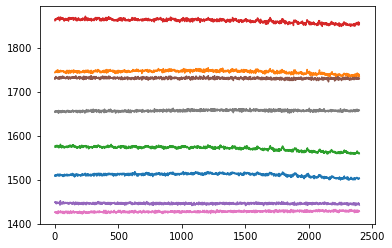

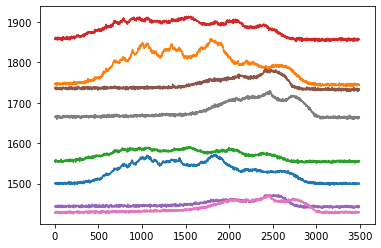

In [17]:
path = os.path.join(EVENTS_CACHE_PATH, 'RawLabelledData/noise')
files = os.listdir(os.path.join(EVENTS_CACHE_PATH, 'RawLabelledData/noise'))
for file in files[0:6]:
    if file.split('_')[-1] == 'data.npy':
        data = np.load(os.path.join(path,file))
        plt.plot(data)
        plt.show()

# Find blobs

In [10]:
mac = 'dca6327d8fa8'
path=RAWDATA_CACHE_PATH
blob_mgr = BlobManager(configuration='rclone')

In [11]:
date = 20210330
blob_list = blob_mgr.list_blobs(container='scouts', subdir=f"{mac}/{str(date)}/raw/")
blob_list = [b for b in blob_list if b.endswith(".raw.gz")]
print('Number of raw data files:', len(blob_list))

Number of raw data files: 115


# Test and visualize

In [12]:
date = 20210330

blob_list = blob_mgr.list_blobs(container='scouts', subdir=f"{mac}/{str(date)}/raw/")
blob_list = [b for b in blob_list if b.endswith(".raw.gz")]
print('Number of raw data files:', len(blob_list))

Number of raw data files: 115


In [13]:
for blob in blob_list[75:76]:
    data, times, labels, start_inds, stop_inds, _meas = create_labelled_data(blob)

Some files exist, not downloading again.
100% complete      [==================================================]

Reading dca6327d8fa8_20210330_raw_20210330T152242Z.raw.gz 1 of 1
raw_start: 2021-03-30 15:23:08
raw_end: 2021-03-30 15:33:03
Found 65 measurements
Running event extraction
len(_meas) 65


In [ ]:
for c in range(0,8):
    plt.plot(data[start_inds[0]:stop_inds[0],c], label=str(channels[c]), color=colors[c])
plt.legend()

In [ ]:
start_inds[0]

In [ ]:
stop_inds[0]

In [ ]:
plt.figure(figsize=(25,5))
for c in range(0,1):
    plt.plot(data[1451375:1800000,c], label=str(channels[c]), color=colors[c])
plt.legend()


In [ ]:
fig, ax1 = plt.subplots()
fig.set_figwidth(25)
color = 'tab:blue'
ax1.set_ylabel('data', color=color)
ax1.plot(data[1451375:1453502,4], color=color)
ax1.tick_params(axis='y', color=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('labelled', color=color)
ax2.plot(labels[1451375:1453502,4], color=color)
ax2.tick_params(axis='y', color=color)
plt.show()

In [ ]:
start_inds[1]

In [ ]:
start_inds[2]


In [ ]:
stop_inds[1]


In [ ]:
stop_inds[2]


In [ ]:
fig, ax1 = plt.subplots()
fig.set_figwidth(25)
color = 'tab:blue'
ax1.set_ylabel('data', color=color)
ax1.plot(data[1462000:1484000,0], color=color)
ax1.tick_params(axis='y', color=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('labelled', color=color)
ax2.plot(labels[1462000:1484000,0], color=color)
ax2.tick_params(axis='y', color=color)
plt.show()

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(labels[1451375:1800000,c], label=str(channels[c]), color=colors[c])


In [ ]:
plt.figure(figsize=(25,5))
plt.plot(data[1451375:1800000,c], label=str(channels[c]), color=colors[c])


In [ ]:
ax = [None]*8
fig, ((ax[0], ax[1], ax[2], ax[3]), (ax[4], ax[5], ax[6], ax[7])) = plt.subplots(nrows=2, ncols=4, sharey=True)
fig.set_figwidth(25)
for c in range(0,8):
    ax[c].plot(labels[1451375:1800000,c], label=str(channels[c]), color=colors[c])
    ax[c].legend()
plt.show()

In [ ]:
for m_id in _meas['Id'].tolist()[0:1]:
    event = fp.Event(m_id).fill()
    event.plot()
    plt.show()

# Run for all - THIS WILL TAKE A WHILE

In [ ]:
if False:
    for blob in blob_list:
        create_labelled_data(blob)

# Run for all dates - THIS WILL TAKE FOREVER

In [ ]:
if True:
    dates = measurements['DateId'].sort_values().unique().tolist()
    for date in dates[0:7]:
        print(date)
        path=RAWDATA_CACHE_PATH
        blob_mgr = BlobManager(configuration='rclone')
        blob_list = blob_mgr.list_blobs(container='scouts', subdir=f"{mac}/{str(date)}/raw/")
        blob_list = [b for b in blob_list if b.endswith(".raw.gz")]
        print('Number of raw data files:', len(blob_list))

        for blob in blob_list:
            create_labelled_data(blob)